In [30]:
from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Github/Face_detector
Dir= 'face_detector/Data/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Github/Face_detector


In [67]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

## Multi-Task Cascaded Convolutional Neural Network for face cropping
* Face detection is the process of automatically locating faces in a photograph and localizing them by drawing a bounding box around their extent.

* We will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled “Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.”

* We will use the implementation provided by Iván de Paz Centeno in the ipazc/mtcnn project. This can also be installed via pip as follows:

In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.2MB/s 


In [32]:
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

def detect_face(image, results):
    x1, y1, w, h = results[0]['box']
    return image[y1: y1+h, x1: x1+ w, :]

/content/drive/My Drive/Github/Face_detector


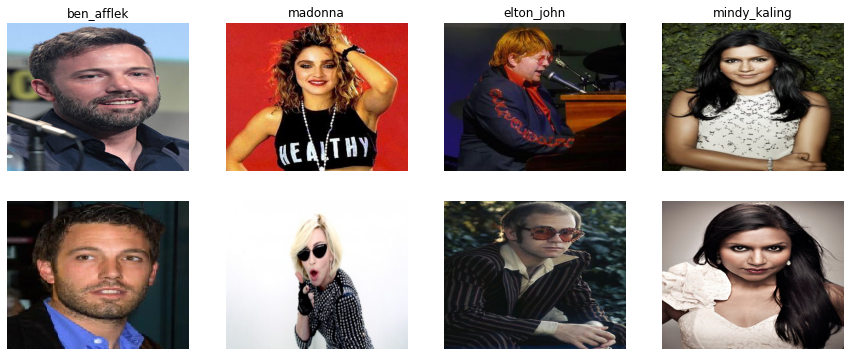

In [33]:
%cd /content/drive/My Drive/Github/Face_detector
Dir= 'face_detector/Data/train'
Peoples= os.listdir(Dir)

f, ax= plt.subplots(2, 4, figsize= (15, 6))


for i, people in enumerate(Peoples):
    random.seed(i)
    path= os.path.join(Dir, people)
    img_path1, img_path2= random.choice(os.listdir(path)), random.choice(os.listdir(path))
    image1= load_img(os.path.join(path, img_path1))
    image2= load_img(os.path.join(path, img_path2))
    
    ax[0][i].imshow(image1, aspect='auto')
    ax[1][i].imshow(image2, aspect='auto')
    ax[0][i].axis('off'); ax[1][i].axis('off')
    ax[0][i].set_title(people)
plt.show()
    
    

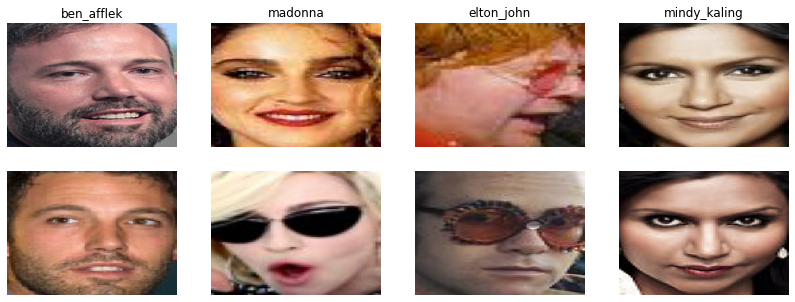

In [35]:
import mtcnn
# create the detector, using default weights
detector = mtcnn.MTCNN()


f, ax= plt.subplots(2, 4, figsize= (14, 5))

for i, people in enumerate(Peoples):
    path= os.path.join(Dir, people)
    random.seed(i)
    img_path1, img_path2= random.choice(os.listdir(path)), random.choice(os.listdir(path))
    image1= load_img(os.path.join(path, img_path1))
    image2= load_img(os.path.join(path, img_path2))
    
    #CROP FACES
    results1 = detector.detect_faces(image1)
    results2 = detector.detect_faces(image2)
    image1= detect_face(image1, results1)
    image2= detect_face(image2, results2)
    
    
    ax[0][i].imshow(image1, aspect='auto')
    ax[1][i].imshow(image2, aspect='auto')
    ax[0][i].axis('off'); ax[1][i].axis('off')
    ax[0][i].set_title(people)
plt.show()

## FACE-NET MODEL

In [87]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# load the model
model = load_model('model/facenet_keras.h5', compile= False)

In [96]:
model.load_weights('weights/facenet_keras_weights.h5')

## PCA

In [89]:
#dir == 'face_detector/Data/train'
def load_data(dir):
  X, Y=[], []
  for i, people_dir in enumerate(os.listdir(dir)):
    print('Processing for:', people_dir)
    path= os.path.join(dir, people_dir)
    for people in tqdm(os.listdir(path)):
      image= load_img(os.path.join(path, people))
      results = detector.detect_faces(image)
      image= detect_face(image, results)
      image = cv2.resize(image, (160, 160))

      X.append(image/255.0)
      Y.append(i)
  return np.array(X), np.array(Y)





In [90]:
X, Y= load_data('face_detector/Data/train')

Processing for: ben_afflek



Processing for: madonna



Processing for: elton_john



Processing for: mindy_kaling


In [91]:
X.shape, Y.shape

((72, 160, 160, 3), (72,))

In [97]:
def Get_features(model, X):
  return model.predict(X)

features= Get_features(model, X)
features.shape

(72, 128)

In [98]:
df=pd.DataFrame(features)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.178773,1.432218,-0.915037,-1.445763,0.509192,-0.660425,0.419656,-0.637107,0.732318,-0.618945,0.229675,-0.792970,-0.583886,0.854973,0.005024,0.719720,-1.256150,-0.706261,-0.972056,-0.050006,1.306482,0.851137,0.704056,-1.071302,0.075997,0.618353,-0.713712,-1.679376,-1.208163,0.378151,0.135083,-0.505234,1.513762,0.340063,-1.283797,2.425451,-0.930421,-1.003609,-2.021143,-0.086434,...,1.112638,-0.816904,0.542633,1.039768,2.558903,0.202852,-0.204914,-0.122573,-0.490712,0.751801,-2.379720,0.549559,0.816386,-1.247124,-0.022194,-0.855152,-1.970212,-1.634088,1.831711,1.503281,-0.544563,1.643519,-0.713823,-0.190140,1.207400,2.445582,0.940185,0.328336,2.122523,-1.199574,0.078310,1.014410,0.944416,1.571979,-0.582642,-0.196950,0.152963,-2.680637,0.417733,1.260036
1,0.954651,0.597775,-2.047925,-0.791714,-1.426486,-0.037487,0.567865,1.169997,-0.409680,-0.121564,1.548781,-1.132514,-1.130976,-0.133551,-0.681903,0.254406,-2.179609,-0.312147,-0.593088,-0.493057,0.358567,0.305396,1.206832,-2.100979,-0.214992,-0.653494,-0.826210,0.173201,-1.249120,1.345912,-1.551609,0.372256,0.141731,1.351471,-1.069651,2.448515,-0.689998,-0.153187,-0.102074,-2.250948,...,0.837314,-1.371017,0.968965,1.449004,0.876267,1.449586,-0.337655,0.812254,-0.989594,-1.425233,-0.104909,1.308312,-0.372751,0.290092,0.188557,-1.166477,-1.932544,0.708650,1.603856,0.631285,-0.334062,0.926347,0.149786,-0.308918,-0.771164,1.350793,1.185502,1.043179,0.821910,-0.274645,0.021424,1.149845,-0.950114,2.290531,0.406727,0.789000,-0.208716,-0.689541,0.401105,-0.409649
2,-0.607808,-0.955217,-1.259119,-0.213970,0.178697,-1.347131,0.041410,0.061574,1.303005,0.804738,-0.017903,-1.111300,0.440687,-0.869905,-2.120329,0.534703,-0.916282,-0.045239,-1.022497,-1.126183,2.315385,-0.132853,-0.274363,-0.009342,1.046248,1.374045,0.565938,-0.163388,1.611590,1.425523,-0.616467,2.022167,0.094447,0.084108,0.043691,0.147646,-2.066511,-0.330026,-2.417474,-0.929016,...,-0.572340,1.412060,0.056892,0.379098,0.750104,0.113812,-0.645728,2.674960,-0.333134,-0.949385,-0.068606,-1.034015,-0.488717,-0.356357,1.294350,-1.997898,-1.263009,0.128299,-0.576743,0.584962,0.258470,-0.744973,1.506737,-0.765428,-0.076210,1.934991,1.625564,0.727931,1.203818,-1.136154,-0.052276,1.178392,1.612323,0.236536,-1.221539,0.572259,0.211015,-0.302300,1.062340,-0.891577
3,-0.335578,0.899643,-1.620652,0.584858,0.091892,-1.322540,0.136408,-0.397452,-0.225083,-0.179664,1.029396,-1.637777,0.251945,-0.283708,0.503296,0.352563,-1.353675,-2.232015,-1.867959,-0.202076,0.953428,0.379815,1.219093,-0.235178,0.471931,-0.361730,-0.019420,0.204248,0.446596,1.167726,-0.110371,-1.231096,1.640798,1.196041,-0.703257,2.349944,-2.055959,-0.763486,-0.935744,-1.353790,...,0.566218,-1.093628,1.644844,2.089247,2.110677,1.205016,-0.743795,0.767326,-1.288412,-0.432036,-1.390760,-0.080440,-0.064958,-0.751545,0.758929,-0.902078,-0.887432,-0.784579,1.666225,0.715546,-0.295729,0.995814,-0.426659,-0.766932,-0.830150,1.065003,1.273436,0.144620,1.853816,-0.690658,0.716592,1.237709,1.188220,1.276432,-0.495317,0.541586,1.293948,-1.335967,0.078106,1.097189
4,1.451886,0.885004,-1.681394,-1.372357,1.386115,-0.506597,0.869384,-0.610288,-0.663709,0.951843,0.833381,-0.051715,0.437205,-1.607635,0.741055,0.143450,-0.989560,-2.215534,-0.823672,-2.256949,1.271236,-0.473046,-0.107575,-0.314990,0.577691,-1.463424,1.328703,1.067171,-1.216749,-0.192455,-0.418993,0.769593,1.289999,0.677083,-0.114372,1.464904,-2.861197,-0.926744,-1.053141,-0.579802,...,1.410739,-0.974690,0.047652,1.429885,1.826760,0.214339,1.871985,0.433480,-2.425757,-1.093320,0.276384,1.852388,-0.091765,0.114549,-0.618922,-1.161856,-1.332149,-0.337922,0.823138,0.910065,-0.586779,-0.440337,-1.079567,-0.172392,-1.415494,0.507113,0.748682,2.284811,1.486794,0.462578,0

In [99]:
import seaborn as sns
from sklearn.decomposition import PCA
# Create a PCA instance:
pca = PCA(n_components=2) 
# Fit pca to 'X'
pca_features = pca.fit_transform(df)
print(pca_features.shape)

(72, 2)


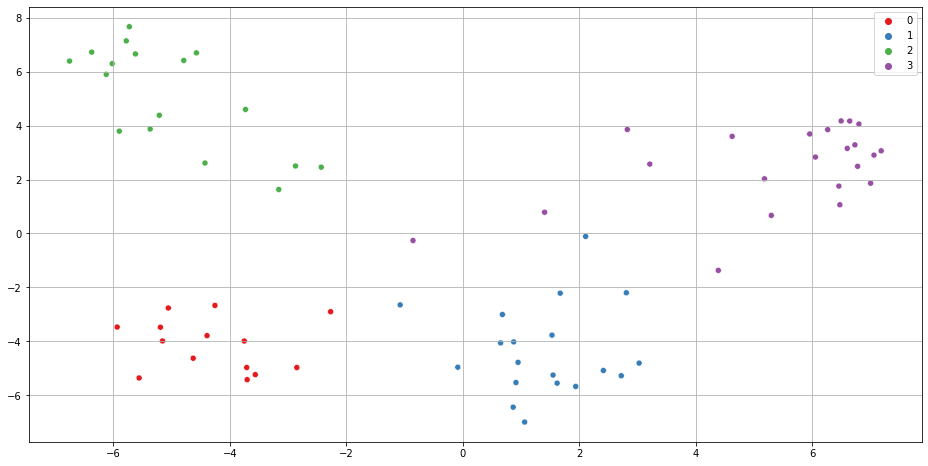

In [100]:
plt.figure(figsize=(16, 8))
plt.grid(True)
sns.scatterplot(x=pca_features[:, 0] , y= pca_features[:, 1], hue = Y, palette='Set1')